In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
import os
import matplotlib.pyplot as plt
from PIL import Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


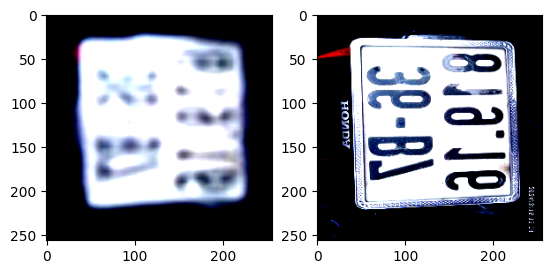

In [2]:
class LicensePlateDataset(Dataset):
    def __init__(self, LR_folder_path,HR_folder_path, resize_tup):
        super().__init__()
        self.LR_folder_path = LR_folder_path
        self.HR_folder_path = HR_folder_path
        self.resize_tup = resize_tup
        self.transforms = transforms.Compose([
            transforms.Resize(self.resize_tup),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225))
        ])
    def __len__(self):
        if os.listdir(self.LR_folder_path) != os.listdir(self.HR_folder_path):
            raise ValueError("HR image number is not same LR image number!")

        return len(os.listdir(self.LR_folder_path))

    def __getitem__(self, index):
        LR_tail = os.listdir(self.LR_folder_path)
        LR_image = Image.open(os.path.join(self.LR_folder_path,LR_tail[index]))
        LR_image = self.transforms(LR_image)
        HR_tail = os.listdir(self.HR_folder_path)
        HR_image = Image.open(os.path.join(self.HR_folder_path,HR_tail[index]))
        HR_image = self.transforms(HR_image)
        return (LR_image, HR_image)

# Path of image folder
LR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_no_augmentation\LR_data\LR_data"
HR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_no_augmentation\HR_data\HR_data"
Dataset = LicensePlateDataset(LR_path, HR_path, (256,256))

image_test1 = Dataset.__getitem__(1)[0]
image_test1 = image_test1.transpose(2,0)
image_test2 = Dataset.__getitem__(1)[1]
image_test2 = image_test2.transpose(2,0)
plt.subplot(1,2,1)
plt.imshow(image_test1)
plt.subplot(1,2,2)
plt.imshow(image_test2)
plt.show()

In [4]:
class DoubleConv(nn.Module):
    def __init__(self,in_channel, out_channel):
        super().__init__()
        self.component = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self,x):
        return self.component(x)

skip_connection = []
class Encoder(nn.Module):
    def __init__(self, in_channel, feature_list):
        super().__init__()
        self.feature_list = feature_list
        self.downs = nn.ModuleList()
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottom = nn.Conv2d(feature_list[-1], feature_list[-1]*2, kernel_size=1)

        for feature in self.feature_list:
            self.downs.append(DoubleConv(in_channel, feature))
            in_channel = feature

    def forward(self,x):
        for down in self.downs:
            x = down(x)
            skip_connection.append(x)
            x = self.maxpool2d(x)
        x = self.bottom(x)
        return x

class TransformInLatent(nn.Module):
    def __init__(self, shape, num_layers):
        super().__init__()
        self.flatten = nn.Flatten()
        self.muy = nn.Linear(shape[1]*shape[2]*shape[3], num_layers)
        self.std = nn.Linear(shape[1]*shape[2]*shape[3], num_layers)
        self.linear_reverse = nn.Linear(num_layers, shape[1]*shape[2]*shape[3])


    def forward(self, x):
        x_flatten = self.flatten(x)
        muy = self.muy(x_flatten)
        std = self.std(x_flatten)
        eps = torch.rand_like(std)
        new_params = muy + eps*std
        x_reversed = self.linear_reverse(new_params)
        out = torch.reshape(x_reversed,(x.shape[0],x.shape[1],x.shape[2],x.shape[3]))
        return out, muy, std


class Decoder(nn.Module):
    def __init__(self, out_channel, reversed_feature_list):
        """
        Reversed_feature_list[0] == laten_space_channel//2
        """
        super().__init__()
        self.ups=nn.ModuleList()
        self.lastConv2d = nn.Conv2d(reversed_feature_list[-1], out_channel,kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        for feature in reversed_feature_list:
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2, padding=0))
            self.ups.append(DoubleConv(feature*2, feature))

    def forward(self, x):
        for i in range(0,len(self.ups),2):
            x = self.ups[i](x)
            if x.shape != skip_connection[len(skip_connection)-1-i//2].shape:
                x = TF.resize(x, size=skip_connection[len(skip_connection)-1-i//2].shape[2:])
            x = torch.cat([skip_connection[len(skip_connection)-1-i//2], x],axis=1)
            x = self.ups[i+1](x)
            # x = self.lastConv2d(x)
        return self.lastConv2d(x)

class VAE(nn.Module):
    def __init__(self, in_channel, feature_list, shape_lattent_vector, num_layers):
        super().__init__()
        self.enc = Encoder(in_channel, feature_list)
        self.trans = TransformInLatent(shape_lattent_vector, num_layers)
        self.dec = Decoder(in_channel, feature_list[::-1])

    def forward(self, x):
        x = self.enc(x)
        x, muy, std = self.trans(x)
        x = self.dec(x)
        return x, muy, std

x = torch.rand(1,3,64,64)
enc = Encoder(3,[64,128,256,512])
out_encoder = enc(x)
shape = out_encoder.shape

vae = VAE(3, [64,128,256,512], shape, 1024)
out_vae = vae(x)
out_vae[0].shape

torch.Size([1, 3, 64, 64])

In [5]:
total_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
total_params

67757123

In [14]:
epochs = 50
device = 'cuda'
loss_fn = nn.MSELoss()
image_dataset = LicensePlateDataset(LR_path, HR_path, (64, 64))
dataloader = DataLoader(image_dataset, batch_size=1, shuffle=True)
vae.to(device)
optimizer = Adam(vae.parameters(), lr = 0.001)

for epoch in range(epochs):
    vae.train()
    sum_loss = 0
    n=len(dataloader)
    for LR_image, HR_image in dataloader:
        LR_image = LR_image.to(device)
        HR_image = HR_image.to(device)
        optimizer.zero_grad()
        HR_output, muy, std = vae(LR_image)

        bce_loss = loss_fn(HR_output, HR_image)
        kl_divergence = -0.5 * torch.sum(1 + std - muy.pow(2) - std.exp())
        loss = bce_loss + kl_divergence

        loss.backward()
        optimizer.step()
        sum_loss+=loss
    print("Epoch {} : Loss {}".format(epoch+1,sum_loss/n))

Epoch 1 : Loss 2.0449955463409424
Epoch 2 : Loss 0.17559637129306793


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 4.95 GiB is allocated by PyTorch, and 160.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


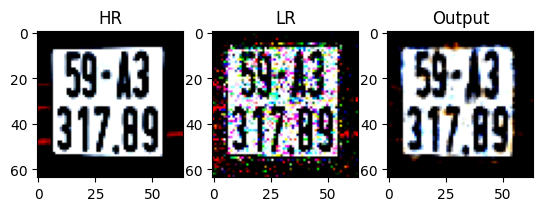

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


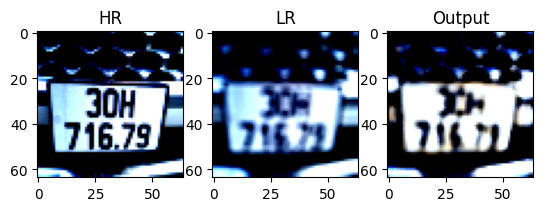

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


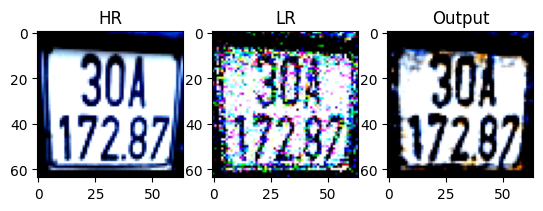

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


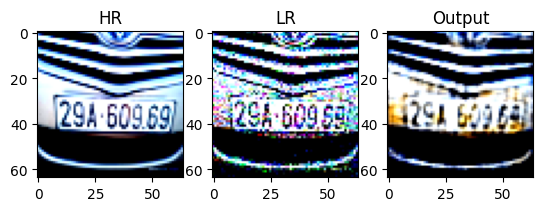

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


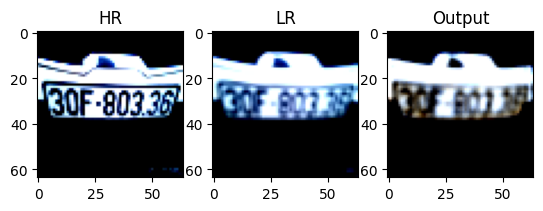

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


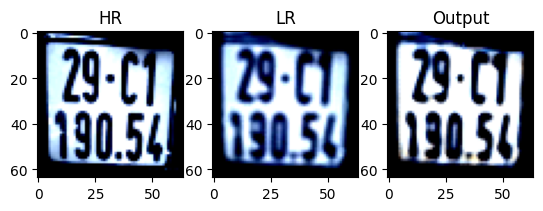

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


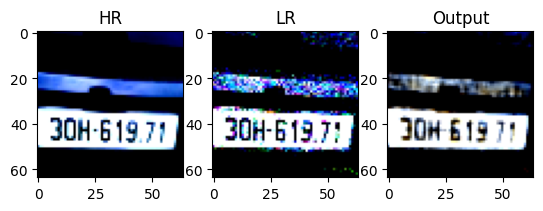

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


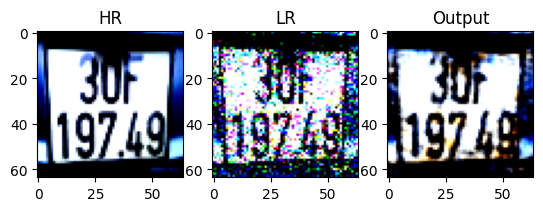

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


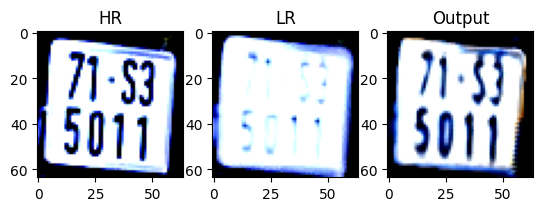

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


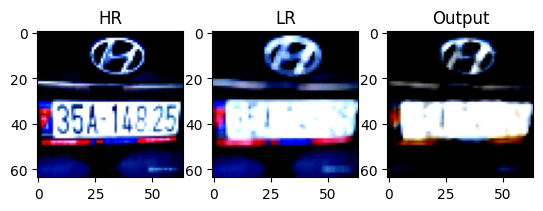

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


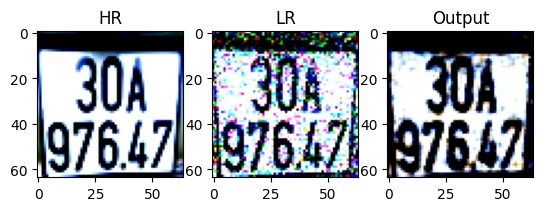

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


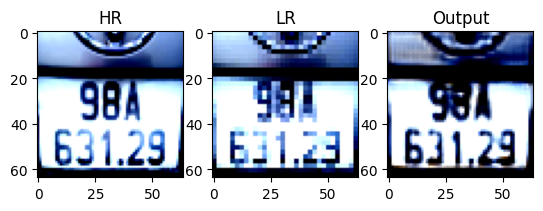

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


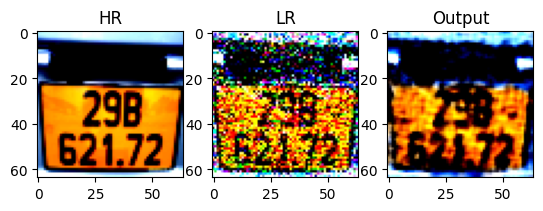

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


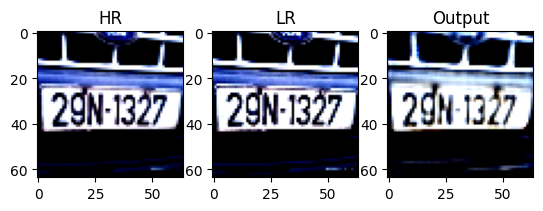

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


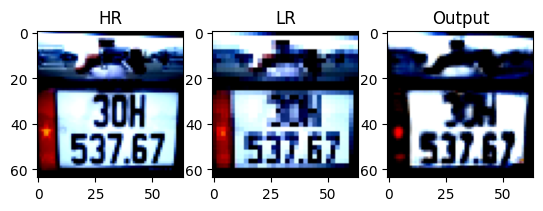

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


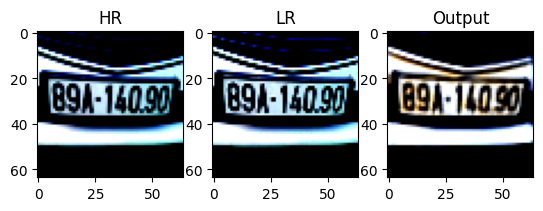

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


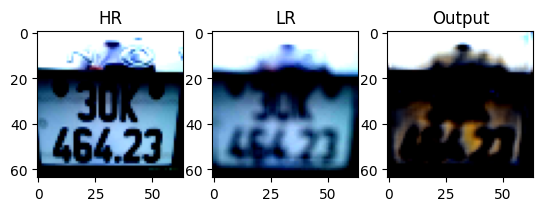

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


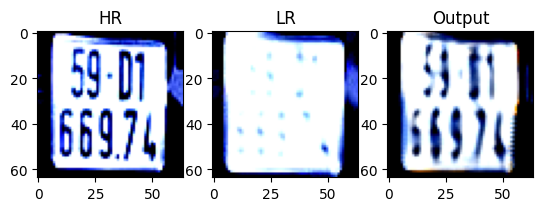

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


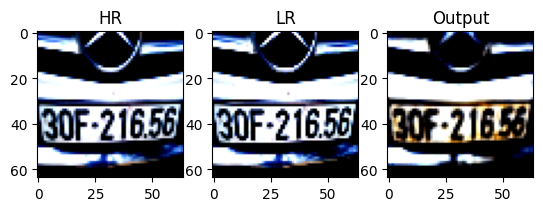

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 4.99 GiB is allocated by PyTorch, and 160.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [16]:
vae.load_state_dict(torch.load('vae.pth'))
device = 'cuda'
vae.to(device)
image_dataset = LicensePlateDataset(LR_path, HR_path, (64, 64))
dataloader = DataLoader(image_dataset, batch_size=1, shuffle=True)
for LR_image, HR_image in dataloader:
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        HR_output = vae(LR_image)[0]
        HR_output = HR_output.squeeze(0)
        HR_output = HR_output.permute(1, 2, 0)
        HR_output = HR_output.cpu().detach().numpy()
        plt.subplot(1,3,1)
        plt.imshow(HR_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.title("HR")
        plt.subplot(1,3,2)
        plt.imshow(LR_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.title("LR")
        plt.subplot(1,3,3)
        plt.imshow(HR_output)
        plt.title("Output")
        plt.show()

In [4]:
vae.load_state_dict(torch.load('vae.pth'))


<All keys matched successfully>

In [5]:
import numpy as np
import cv2


def calculate_psnr(original, compressed):
    # Đảm bảo hai hình ảnh có cùng kích thước
    assert original.shape == compressed.shape, "Hình ảnh phải có cùng kích thước"

    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')  # PSNR vô cùng nếu không có sai khác

    max_pixel = 4.5  # Giả sử hình ảnh có độ sâu 8-bit
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np

def calculate_ssim(img1, img2):
    
    if img1.shape != img2.shape:
        raise ValueError("Hai ảnh phải có cùng kích thước.")

    # Tách các kênh màu (RGB)
    ssim_values = []
    for i in range(3):  # Duyệt qua 3 kênh màu
        ssim_value = ssim(img1[:, :, i], img2[:, :, i], data_range=img2[:, :, i].max() - img2[:, :, i].min())
        ssim_values.append(ssim_value)

    # Tính SSIM trung bình trên 3 kênh
    return np.mean(ssim_values)

import cv2
import numpy as np

def calculate_nmse(img1, img2):
    
    # Kiểm tra kích thước ảnh
    if img1.shape != img2.shape:
        raise ValueError("Hai ảnh phải có cùng kích thước.")

    # Tính NMSE
    numerator = np.sum((img1 - img2) ** 2)
    denominator = np.sum(img2 ** 2)
    nmse_value = numerator / denominator if denominator != 0 else float('inf')
    return nmse_value


In [6]:
import numpy as np
device = 'cuda'
vae.to(device)
psnr_score = []
ssim_score = []
nmse_score = []
image_dataset = LicensePlateDataset(LR_path, HR_path, (64, 64))
dataloader = DataLoader(image_dataset, batch_size=1, shuffle=False)
for LR_image, HR_image in dataloader:
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        HR_output = vae(LR_image)[0]
        HR_output = HR_output.squeeze(0)
        HR_output = HR_output.permute(1, 2, 0)
        HR_output = HR_output.detach().cpu().numpy()
        
        HR_image = HR_image.squeeze(0).permute(1,2,0)
        HR_image = HR_image.detach().cpu().numpy()
        psnr_score.append(calculate_psnr(HR_image,HR_output))
        ssim_score.append(calculate_ssim(HR_image,HR_output))
        nmse_score.append(calculate_nmse(HR_image,HR_output))

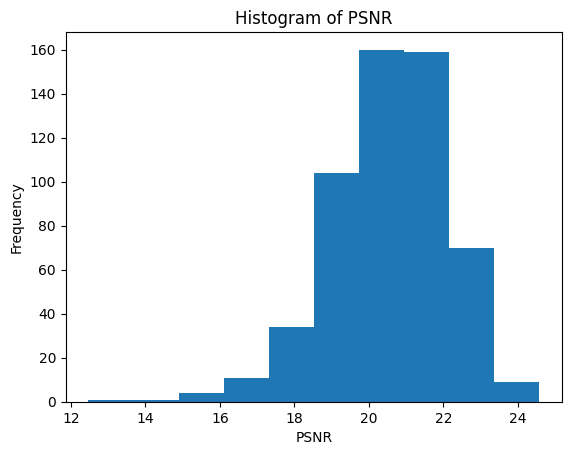

In [7]:
plt.hist(psnr_score)
plt.xlabel("PSNR")
plt.ylabel("Frequency")
plt.title("Histogram of PSNR")
plt.show()

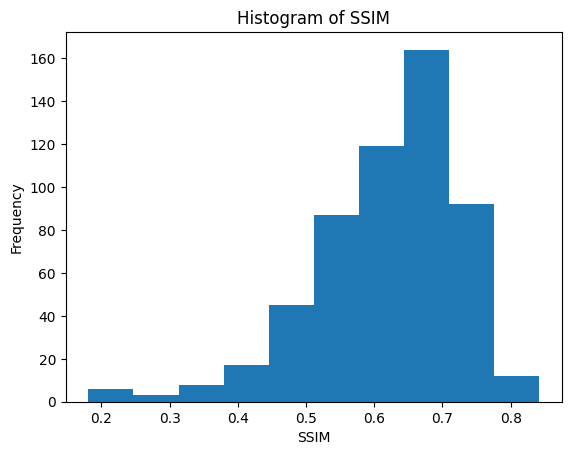

In [8]:
plt.hist(ssim_score)
plt.xlabel("SSIM")
plt.ylabel("Frequency")
plt.title("Histogram of SSIM")
plt.show()

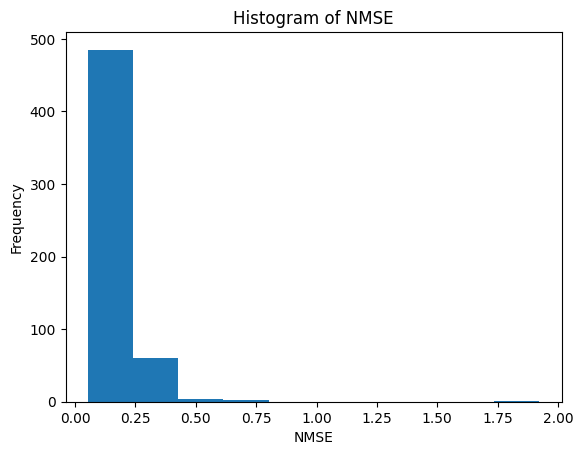

In [9]:
plt.hist(nmse_score)
plt.xlabel("NMSE")
plt.ylabel("Frequency")
plt.title("Histogram of NMSE")
plt.show()

In [12]:
import pandas as pd
VAE_dict = {"METHOD":"Variational Auto Encoder","PSNR":psnr_score, "SSIM":ssim_score,"NMSE":nmse_score}
VAE_df = pd.DataFrame(VAE_dict)
VAE_df.shape

(553, 4)

In [11]:
VAE_df.to_csv("VAE_df.csv")